Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [466]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Get name of GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [467]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

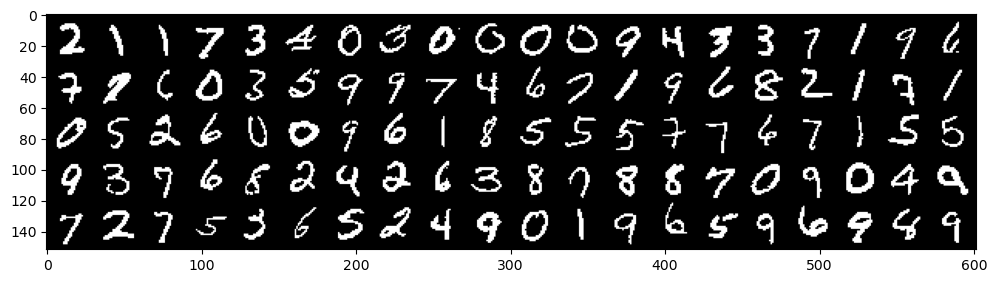

In [468]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (8 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting": this would in particular mean architectures which perform better than a feed-forward network, while having fewer parameters.
	- *In particular* for full credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions.


In [469]:
class Encoder(nn.Module):

	def __init__(self, D_latent):
		"""
		Initialize the Encoder `nn.Module`.

		This will operate on inputs of shape (batch_size, 1, 28, 28).

		INPUTS:
		D_latent: size of latent space (integer)

		"""
		super().__init__()
		self.D_latent = D_latent

		# Define any networks (which extend 'nn.Module') here:
		# Anything that has parameters should be defined here!

		# e.g., a linear layer could be defined as
		# self.fc = nn.Linear(784, D_latent)
		#
		# Later on in the `.forward` method, you then can call this.
		#
		# Some ``useful'' layers include:
		#
		# nn.Linear, nn.ReLU, nn.Conv2d, nn.Sequential, nn.Softplus, ...

		# YOUR CODE HERE

		# Convolutional section
		self.encoder_cnn = nn.Sequential(nn.Conv2d(1, 4, stride=2, kernel_size = (3,2), padding= (1,0)),
				   nn.ReLU(),
				   nn.BatchNorm2d(4),
				   nn.Conv2d(4, 8, kernel_size=(3,2), stride=2, padding=(1,0)),
				   nn.BatchNorm2d(8),
				   nn.ReLU(),
				   nn.Conv2d(8, 16, kernel_size=(3,2), stride=2, padding=0),
				   nn.BatchNorm2d(16),
				   nn.ReLU())

		# Flatten layer
		self.flatten = nn.Flatten(start_dim=1)

		# Linear section
		self.encoder_lin = nn.Sequential(nn.Linear(144, 48))

		# Mu and Sigma separate linear layers
		self.linear_mu = nn.Linear(48, self.D_latent)
		self.linear_sigma = nn.Linear(48, self.D_latent)


	def forward(self, X):
		""" Return a distribution q(z | x).

		Remember you can access and variables or `nn.Module` instances defined in the constructor.

		INPUT:
		X    : torch.FloatTensor containing zeros and ones; shape = (batch_size, 1, 28, 28)

		OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, D_latent)
		"""

		# YOUR CODE HERE

		# First three layers on X
		X = self.encoder_cnn(X)
		X = self.flatten(X)
		X = self.encoder_lin(X)

		# Mu
		mu = self.linear_mu(X)
		mu = mu.reshape(X.shape[0], self.D_latent)

		# Sigma
		sigma = self.linear_sigma(X)
		sigma = torch.exp(sigma)
		sigma = sigma.reshape(X.shape[0], self.D_latent)

		assert mu.shape == (X.shape[0], self.D_latent)
		assert mu.shape == sigma.shape

		return dist.Normal(mu, sigma)


In [470]:
from pytorch_model_summary import summary
print(summary(Encoder(10), torch.zeros((1, 1, 28, 28)), show_input=True))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 1, 28, 28]              28              28
            ReLU-2      [1, 4, 14, 14]               0               0
     BatchNorm2d-3      [1, 4, 14, 14]               8               8
          Conv2d-4      [1, 4, 14, 14]             200             200
     BatchNorm2d-5        [1, 8, 7, 7]              16              16
            ReLU-6        [1, 8, 7, 7]               0               0
          Conv2d-7        [1, 8, 7, 7]             784             784
     BatchNorm2d-8       [1, 16, 3, 3]              32              32
            ReLU-9       [1, 16, 3, 3]               0               0
        Flatten-10       [1, 16, 3, 3]               0               0
         Linear-11            [1, 144]           6,960           6,960
         Linear-12             [1, 48]             490             490
     

In [471]:
	class Decoder(nn.Module):

	def __init__(self, D_latent):
		"""
		Initialize the Decoder `nn.Module`.

		This will operate on inputs of shape (batch_size, D_latent).

		INPUTS:
		D_latent: size of latent space (integer)

		"""
		super().__init__()
		self.D_latent = D_latent

		# Define your networks here

		# YOUR CODE HERE

		self.decoder_lin = nn.Sequential(
			nn.Linear(self.D_latent, 48),
			nn.ReLU(),
			nn.Linear(48, 144))

		self.unflatten = nn.Unflatten(dim=1,
		unflattened_size=(16, 3, 3))

		self.decoder_conv = nn.Sequential(
			nn.ConvTranspose2d(16, 8, 3,
			stride=2, output_padding=0),
			nn.BatchNorm2d(8),
			nn.ReLU(),
			nn.ConvTranspose2d(8, 4, 3, stride=2,
			padding=1, output_padding=1),
			nn.BatchNorm2d(4),
			nn.ReLU(),
			nn.ConvTranspose2d(4, 1, 3, stride=2,
			padding=1, output_padding=1)
		)

	def forward(self, Z):
		""" Return a distribution p(x | z)

		INPUT:
		X    : torch.FloatTensor, real-valued, shape = (batch_size, D_latent)

		OUTPUT: a `torch.Distribution` instance, defined on values of shape = (batch_size, 1, 28, 28)
		"""

		# Make sure that the returned value has the right shape! e.g.:
		#return dist.Bernoulli(self.net(Z).reshape(-1, 1, 28, 28))

		# YOUR CODE HERE
		Z = self.decoder_lin(Z)
		Z = self.unflatten(Z)
		Z = self.decoder_conv(Z)
		Z = torch.sigmoid(Z)
		return dist.Bernoulli(Z.reshape(-1, 1, 28, 28))

In [472]:
from pytorch_model_summary import summary
print(summary(Decoder(10), torch.zeros((1,10)), show_input=True))

--------------------------------------------------------------------------
         Layer (type)         Input Shape         Param #     Tr. Param #
             Linear-1             [1, 10]             528             528
               ReLU-2             [1, 48]               0               0
             Linear-3             [1, 48]           7,056           7,056
          Unflatten-4            [1, 144]               0               0
    ConvTranspose2d-5       [1, 16, 3, 3]           1,160           1,160
        BatchNorm2d-6        [1, 8, 7, 7]              16              16
               ReLU-7        [1, 8, 7, 7]               0               0
    ConvTranspose2d-8        [1, 8, 7, 7]             292             292
        BatchNorm2d-9      [1, 4, 14, 14]               8               8
              ReLU-10      [1, 4, 14, 14]               0               0
   ConvTranspose2d-11      [1, 4, 14, 14]              37              37
Total params: 9,097
Trainable params:

# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a single-sample Monte Carlo estimate of

$$ELBO(X) = \mathbb{E}_{q(Z | X)}\left[ \log \left [ \frac{p(Z)p(X | Z)}{q(Z | X)} \right ] \right ]$$

where $q(Z | X)$ and $p(X | Z)$ are returned by the `Encoder` and `Decoder` classes you defined above.


In [473]:
def ELBO_VAE(enc, dec, X):
	"""

	INPUT:
	enc : Instance of `Encoder` class, which returns a distribution
		  over Z when called on a batch of inputs X
	dec : Instance of `Decoder` class, which returns a distribution
		  over X when called on a batch of inputs Z
	X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28).

	"""

	# YOUR CODE HERE

	# For when using a GPU
	X.to(device)

	# Reparamaterisation
	batch_size = X.shape[0]
	latent_dims  = enc(X).sample().shape[1]

	noise = dist.Normal(0,1).sample((batch_size,latent_dims))
	reparam_enc = enc(X).loc + (enc(X).scale * noise)

	# Reconstruction
	x_hat = dec(reparam_enc).probs
	eps = 1e-8 # for numeric stability
	bce = X * torch.log(x_hat + eps) + (1-X) * torch.log(1-x_hat + eps)
	reconstruction = torch.sum(bce, dim = (1,2,3))

	# KL divergence
	kl_dist = -0.5 * torch.sum(1 + enc(X).scale - enc(X).loc.pow(2) - enc(X).scale.exp(), dim=1)

	return reconstruction - kl_dist

# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [474]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

# Move NNs to GPU (if available)
enc.to(device)
dec.to(device)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))

In [475]:
def run_training(N_epochs):
	""" Outer loop for training the VAE

		Calls your `ELBO_VAE` function!
	"""
	for epoch in range(N_epochs):
		train_loss = 0.0
		for (X, _) in train_loader:
			opt_vae.zero_grad()
			loss = -ELBO_VAE(enc, dec, X.to(device)).mean()
			loss.backward()
			opt_vae.step()
			train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
		print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [476]:
# ignore this cell (placeholder)


In [477]:
N_epochs = 10 # Note that you may want to run more epochs!
run_training(N_epochs)

Epoch 0, train loss = 251.2526
Epoch 1, train loss = 146.9782
Epoch 2, train loss = 127.8485
Epoch 3, train loss = 114.4663
Epoch 4, train loss = 104.6155
Epoch 5, train loss = 97.7497
Epoch 6, train loss = 93.3015
Epoch 7, train loss = 90.3506
Epoch 8, train loss = 88.3738
Epoch 9, train loss = 86.8004


In [478]:
# Moving back to CPU for charts
enc.to("cpu")
dec.to("cpu")

Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=10, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=144, bias=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(16, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Do reconstructions look like the input?

Reconstruction accuracy: 0.93


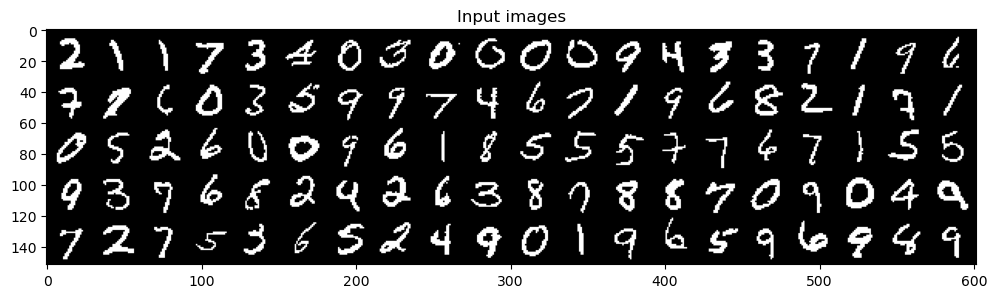

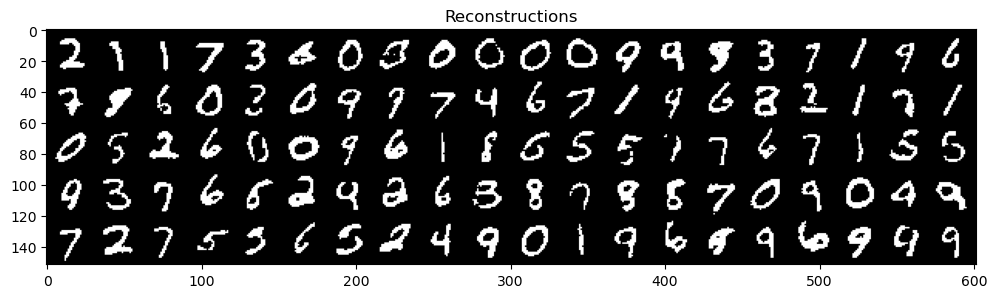

In [479]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
	plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))

print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

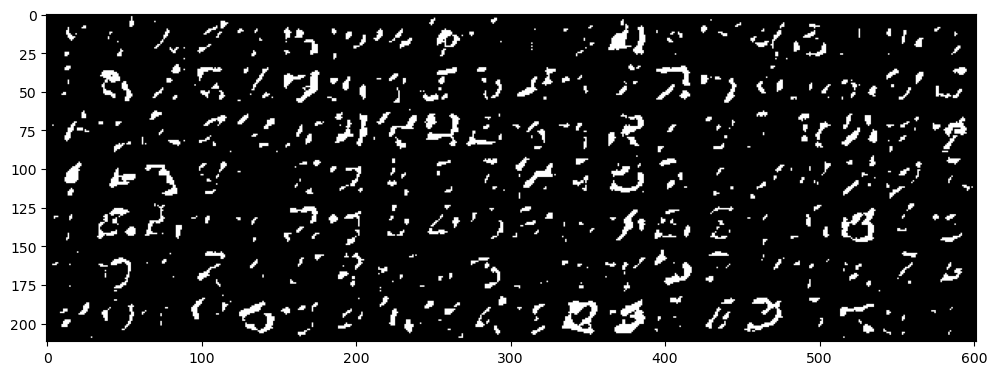

In [480]:
plt.figure(figsize=(12,5))
with torch.no_grad():
	plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

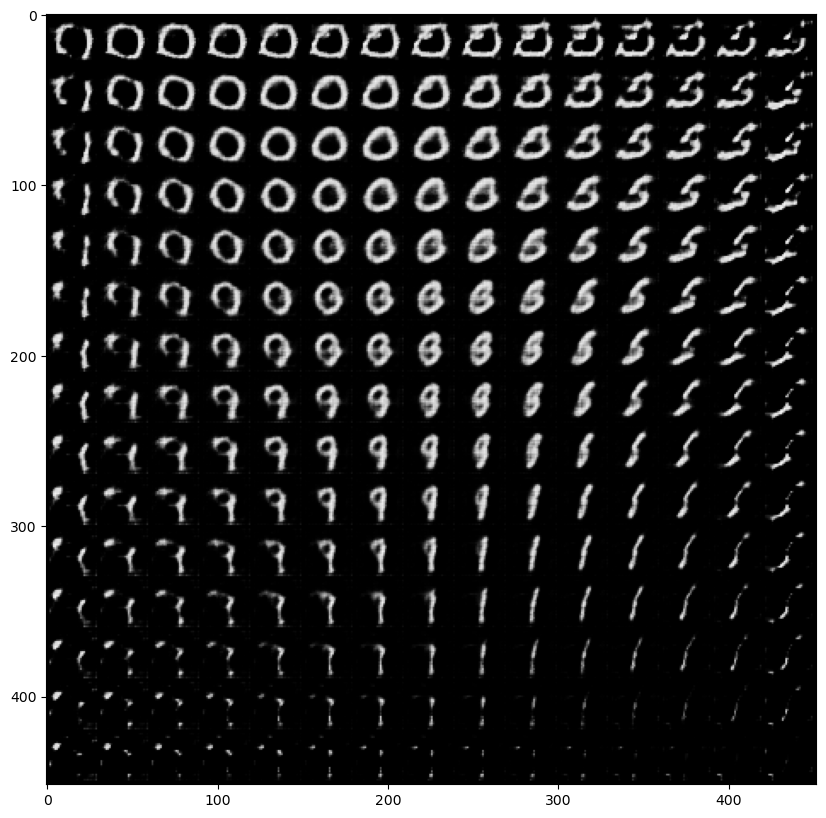

In [481]:
def plot_2d_latent(encoder, decoder):
	""" If this is a 2d latent space, it plots the latent space
		If the latent space is larger than 2d, then it plots a 2d cross-section """
	W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
	points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
	XX, YY = torch.meshgrid(points, points)
	XXYY = torch.stack((XX, YY)).reshape(2, -1).T
	with torch.no_grad():
		out = dec(XXYY @ W).mean
	plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [482]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [483]:
# TRUE ACCURACY
accuracies = []
for _ in range(50):
	X_random_batch, _ = next(iter(train_loader))
	accuracies.append((X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

print("Mean:", np.mean(accuracies))
print("Min:", np.min(accuracies))
print("Max:", np.max(accuracies))

Mean: 0.9298196423053742
Min: 0.9238520264625549
Max: 0.9354974627494812


In [484]:
# Check number of params
print("Encoder # parameters:", sum([a.numel() for a in Encoder(10).parameters()]))
print("Decoder # parameters:", sum([a.numel() for a in Decoder(10).parameters()]))

Encoder # parameters: 9008
Decoder # parameters: 9097


In [485]:
# grading


In [486]:
# grading


In [487]:
# grading


In [488]:
# grading


In [489]:
# grading


In [490]:
# grading


In [491]:
# grading
